# Задание 4.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  


In [1]:
# Запустите эту ячейку если работаете в Colab
import os
if not os.path.exists('PyTorch_CNN.ipynb'):
    !git clone https://github.com/balezz/tad_ml_dl_2021.git
%cd tad_ml_dl_2021/data
! wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat
%cd ../Assignment4

Cloning into 'tad_ml_dl_2021'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 188 (delta 45), reused 37 (delta 13), pack-reused 92
Receiving objects: 100% (188/188), 1.30 MiB | 6.45 MiB/s, done.
Resolving deltas: 100% (68/68), done.
/content/tad_ml_dl_2021/data
--2021-04-01 13:31:57--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  19.9MB/s    in 11s     

2021-04-01 13:32:09 (15.2 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2021-04-01 13:32:09--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.ed

In [2]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [3]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [4]:
# First, lets load the dataset
data_train = dset.SVHN('../data',download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('../data', split='test', download=True,
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Using downloaded and verified file: ../data/train_32x32.mat
Using downloaded and verified file: ../data/test_32x32.mat


Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [5]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [6]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [7]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [8]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Num of epoch: %i / %i Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (epoch + 1, num_epochs, ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
      x = x.to(device)
      y = y.to(device)
      prediction = model(x)    
      _, indices = torch.max(prediction, 1)
      correct_samples += torch.sum(indices == y)
      total_samples += y.shape[0]
      
    test_accuracy = float(correct_samples) / total_samples
    assert 0 <= test_accuracy <= 1 ,"Accuracy error"
    
    

    return test_accuracy

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Num of epoch: 1 / 5 Average loss: 1.337094, Train accuracy: 0.556701, Val accuracy: 0.756399
Num of epoch: 2 / 5 Average loss: 0.678953, Train accuracy: 0.793400, Val accuracy: 0.813255
Num of epoch: 3 / 5 Average loss: 0.586687, Train accuracy: 0.824643, Val accuracy: 0.814347
Num of epoch: 4 / 5 Average loss: 0.538361, Train accuracy: 0.839556, Val accuracy: 0.825404
Num of epoch: 5 / 5 Average loss: 0.509404, Train accuracy: 0.848428, Val accuracy: 0.843901


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [9]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', download=True,
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


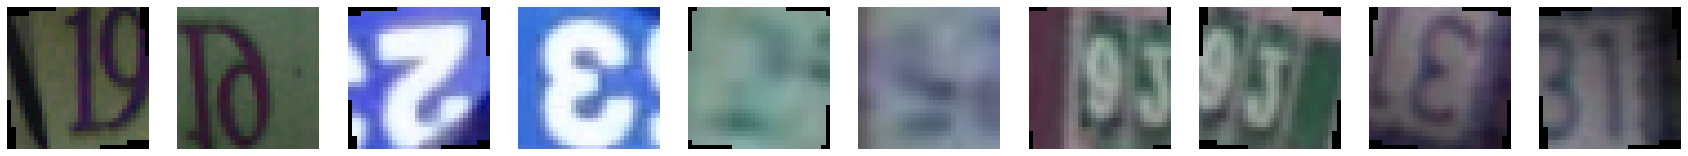

In [10]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [11]:
# TODO: 
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

data_aug_train = dset.SVHN('./', download=True,
                       transform=tfs
                      )
# TODO create new instances of loaders with the augmentations you chose
train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


Using downloaded and verified file: ./train_32x32.mat


In [12]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Num of epoch: 1 / 5 Average loss: 1.158190, Train accuracy: 0.622325, Val accuracy: 0.768207
Num of epoch: 2 / 5 Average loss: 0.934934, Train accuracy: 0.699638, Val accuracy: 0.747526
Num of epoch: 3 / 5 Average loss: 0.864833, Train accuracy: 0.723851, Val accuracy: 0.727937
Num of epoch: 4 / 5 Average loss: 0.826156, Train accuracy: 0.737928, Val accuracy: 0.712102
Num of epoch: 5 / 5 Average loss: 0.798816, Train accuracy: 0.744873, Val accuracy: 0.731486


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

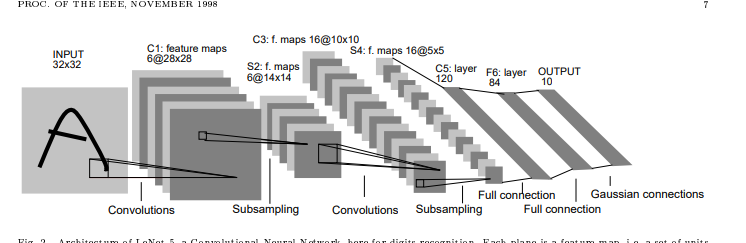

In [13]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
    nn.Conv2d(3,6,kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(kernel_size=2,stride=2),

    nn.Conv2d(6,16,kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(kernel_size=2,stride=2),

    Flattener(),
    nn.Linear(5 * 5 * 16,120),
    nn.Tanh(),

    nn.Linear(120,84),
    nn.Tanh(),

    nn.Linear(84,10)
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [14]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Num of epoch: 1 / 10 Average loss: 2.229610, Train accuracy: 0.198734, Val accuracy: 0.235138
Num of epoch: 2 / 10 Average loss: 1.757334, Train accuracy: 0.404259, Val accuracy: 0.633472
Num of epoch: 3 / 10 Average loss: 1.042211, Train accuracy: 0.667338, Val accuracy: 0.708757
Num of epoch: 4 / 10 Average loss: 0.825573, Train accuracy: 0.739208, Val accuracy: 0.748686
Num of epoch: 5 / 10 Average loss: 0.728325, Train accuracy: 0.769802, Val accuracy: 0.799604
Num of epoch: 6 / 10 Average loss: 0.661910, Train accuracy: 0.790841, Val accuracy: 0.782882
Num of epoch: 7 / 10 Average loss: 0.625322, Train accuracy: 0.803808, Val accuracy: 0.790321
Num of epoch: 8 / 10 Average loss: 0.593535, Train accuracy: 0.813398, Val accuracy: 0.812163
Num of epoch: 9 / 10 Average loss: 0.572064, Train accuracy: 0.819558, Val accuracy: 0.819535
Num of epoch: 10 / 10 Average loss: 0.549036, Train accuracy: 0.826946, Val accuracy: 0.828408


# Подбор гиперпараметров

In [15]:
%%time
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e-3, 1e-4]
anneal_coeff = 0.2
anneal_epochs = [1, 2, 3]
reg = [1e-6, 1e-7]

batch_size = 64
epoch_num = 10

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!

# TODO: Your code here!
params_grid = [(i,j,k) for i in learning_rates for j in anneal_epochs for k in reg]
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

for i,param in enumerate(params_grid):
  lenet_model.apply(weight_reset)
  optimizer = optim.SGD(lenet_model.parameters(), lr=param[0], weight_decay=param[2])
  loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, param[1])
  run_record[Hyperparams(*param)] = RunResult(lenet_model, train_history, val_history, val_history[-1])
  print(f"Took time {i + 1} / {len(params_grid)}")


Num of epoch: 1 / 1 Average loss: 2.305721, Train accuracy: 0.136505, Val accuracy: 0.146543
Took time 1 / 12
Num of epoch: 1 / 1 Average loss: 2.294446, Train accuracy: 0.127905, Val accuracy: 0.155826
Took time 2 / 12
Num of epoch: 1 / 2 Average loss: 2.304845, Train accuracy: 0.130345, Val accuracy: 0.146748
Num of epoch: 2 / 2 Average loss: 2.281720, Train accuracy: 0.163720, Val accuracy: 0.174732
Took time 3 / 12
Num of epoch: 1 / 2 Average loss: 2.293268, Train accuracy: 0.128246, Val accuracy: 0.152072
Num of epoch: 2 / 2 Average loss: 2.271776, Train accuracy: 0.181893, Val accuracy: 0.187564
Took time 4 / 12
Num of epoch: 1 / 3 Average loss: 2.303037, Train accuracy: 0.102020, Val accuracy: 0.119173
Num of epoch: 2 / 3 Average loss: 2.280916, Train accuracy: 0.168242, Val accuracy: 0.189134
Num of epoch: 3 / 3 Average loss: 2.264932, Train accuracy: 0.189588, Val accuracy: 0.187769
Took time 5 / 12
Num of epoch: 1 / 3 Average loss: 2.294245, Train accuracy: 0.148807, Val accu

In [16]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))

Best validation accuracy: 0.19, best hyperparams: Hyperparams(learning_rate=0.001, anneal_epochs=3, reg=1e-06)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [17]:
best_model =nn.Sequential(
            nn.Conv2d(3, 16,3,padding=1), #16 * 32 * 32
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),

            nn.Conv2d(16, 32, 3, padding=1), # 32 * 32 * 32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),

            nn.Conv2d(32, 64, 3, padding=1), # 64 * 32 * 32
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),

            nn.Conv2d(64, 128, 3, padding=1), #128 * 32 * 32
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),

            nn.Conv2d(128, 256, 3, padding=1), #256 * 32 * 32
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), # 256 * 16 * 16
            nn.Dropout(p=0.1),

            nn.Conv2d(256, 256, 3, padding=1), #256 * 16 * 16
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), # 256 * 8 * 8
            nn.Dropout(p=0.1),

            nn.Conv2d(256, 256, 3, padding=1), #256 * 8 * 8
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), # 256 * 4 * 4
            nn.Dropout(p=0.1),

            nn.Conv2d(256, 256, 3, padding=1), #256 * 4 * 4
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),

            nn.Conv2d(256, 256, 3, padding=1), #256 * 4 * 4
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), # 256 * 2 * 2
            nn.Dropout(p=0.1),

            Flattener(),
            nn.Linear(256 * 2 * 2, 100),
            nn.Dropout(p=0.5),
            nn.Linear(100,10)
          )
best_model.apply(weight_reset)
best_model = best_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(best_model.parameters(), lr=1e-4, weight_decay=0.0006)
loss_history, train_history, val_history = train_model(best_model, train_aug_loader, val_loader, loss, optimizer, 10)


Num of epoch: 1 / 10 Average loss: 1.829162, Train accuracy: 0.358172, Val accuracy: 0.767047
Num of epoch: 2 / 10 Average loss: 0.700198, Train accuracy: 0.778999, Val accuracy: 0.865470
Num of epoch: 3 / 10 Average loss: 0.519284, Train accuracy: 0.839795, Val accuracy: 0.886902
Num of epoch: 4 / 10 Average loss: 0.455963, Train accuracy: 0.859400, Val accuracy: 0.904102
Num of epoch: 5 / 10 Average loss: 0.409806, Train accuracy: 0.875013, Val accuracy: 0.903010
Num of epoch: 6 / 10 Average loss: 0.386222, Train accuracy: 0.882623, Val accuracy: 0.912088
Num of epoch: 7 / 10 Average loss: 0.359938, Train accuracy: 0.891922, Val accuracy: 0.916661
Num of epoch: 8 / 10 Average loss: 0.345969, Train accuracy: 0.897212, Val accuracy: 0.919255
Num of epoch: 9 / 10 Average loss: 0.328224, Train accuracy: 0.903013, Val accuracy: 0.918231
Num of epoch: 10 / 10 Average loss: 0.313441, Train accuracy: 0.905795, Val accuracy: 0.928060


In [18]:
from torchsummary import summary
summary(best_model,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,640
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,496
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
          Dropout-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 32, 32]          73,856
      BatchNorm2d-14          [-1, 128,

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [19]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
best_model.eval()
correct_samples = 0
total_samples = 0
for i_step, (x, y) in enumerate(test_loader):
  x = x.to(device)
  y = y.to(device)
  prediction = best_model(x)    
  _, indices = torch.max(prediction, 1)
  correct_samples += torch.sum(indices == y)
  total_samples += y.shape[0]
final_test_accuracy = float(correct_samples) / total_samples
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.9337354025814383
